# Groupe non officiel 1
# Livrable 1 - Classification binaire Création du model

|Auteur|Centre|
|---|---|
|ACQUART Quentin|Aix-en-Provence|
|DIMEGLIO Nicolas|Aix-en-Provence|
|ROMANO Sébastien|Aix-en-Provence|
|SIXDENIER Alexandre|Aix-en-Provence|
|VESSERON Alexandre|Aix-en-Provence|

## Rappel du sujet
L'entreprise voulant automatiser la sélection de photos pour l'annotations, le but est de fournir une méthode de classification binaire afin de filtrer les images qui ne sont pas des photos du dataset de départ. Pour ce faire nous allons nous appuyer sur l'architecture des réseau de neurones, ainsi que l'analyse des résultats obtenus.
Toutes les parties doivent être détaillée dans le notebook :
    - les paramètre du réseau,
    - la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

## Analyse à effectuer
- Graphique contenant l'évolution de l'erreur d’entraînement ainsi que de l'erreur de test
- Graphique l'évolution de l'accuracy pour ces deux datasets.

- L'analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).

- Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop out, early-stopping, ...


## Import des différentes bibliothèques

In [1]:
import pathlib
import zipfile
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
from PIL import Image as Image
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models

## Téléchargement des données et dezippage
Pour cette partie se réferrer au notebook [Préparation des données](Préparation_des_données.ipynb#section_1)
## Récupération des données
Une fois les datasets mis en place, séléctionnez le dataset à utiliser dans la variable `data_dir`

In [2]:
clean_dataset = "../Dataset/Project_Dataset_Clean"
light_dataset = "../Dataset/Project_Dataset_Test"

data_dir = clean_dataset

data_dir = pathlib.Path(data_dir)

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [3]:
image_h = 180
image_w = 180
batch_s = 32

## Préparation des données

Nous devons partager le jeu de données en jeu d'entrainement et de validation.


## Normalisation des données
Nous allons utiliser la fonction de création de jeu de données par répertoire.
<br>La fonction permet de transformer les images pour correspondre aux longueur et largeur définies.
<br>Les images pouvant être sous différent format nous normalisons les images en les transformant en image couleur rgb.

Nos dataset sont donc composées d'image en 180 par 180 et composées de 3 dimensions couleurs.

In [4]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'training',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.20,
  subset = 'validation',
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

Found 41396 files belonging to 5 classes.
Using 33117 files for training.
Found 41396 files belonging to 5 classes.
Using 8279 files for validation.


Nous récupérons en sortie le nombre d'image qui constitue nos jeux d'entrainement et de test.

## Exploration et visualisation des données
Commençons, tout d'abord par afficher le nom des différentes classes de nos données.

In [5]:
class_names =  train_set.class_names #A COMPLETER
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


Afin de vérifier la bonne récupération des données, nous allons afficher quelques images random issues de tout nos dossiers.

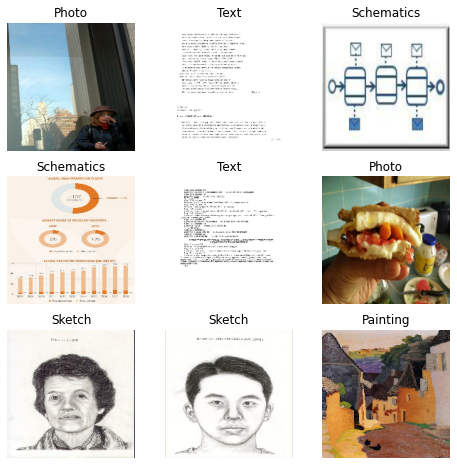

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

On voudrait aussi connaître la taille des données, afin de controler les performances du modèle.

In [7]:
images, labels = next(iter(train_set))
print(images.shape)
print(labels.shape)

(32, 180, 180, 3)
(32,)


## Configuration de l'environnement pour l'entrainement

- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois.
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Le modèle de réseau de neurones convolutif (CNN)

![CNN](images/CNN.jpg)

Notre CNN à pour but de classifier des images en différentes classes.
Pour ce faire nous allons utiliser des couches successives de Convolution et de MaxPooling avec une fonction d'activation ReLU.
Les couches de convolutions vont nous permettre d'identifier des features successivement. Les couches de MaxPooling nous permettent de réduire la taille de l'output des couches de convolutions.
La fonction d'activation ReLU, va permettre d'éliminer les entrées négatives afin de n'activer qu'un certain nombre de neurones.

#### Création du modèle

L'objectif ici est de classer les images en différentes classes.
<br>Nous avons choisi un modèle à 4 couches dans un soucis de compromis temps d'apprentissage/précision.

In [9]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, [3,3], activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, [3,3],activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, [3,3],activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(8, [3,3],activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5),

])

#### Régularisation

L'objectif de  la régularisation est de prévenir le surentrainement, dans l'objectif d'améliorer les performances.
<br>Nous utilisons ici une méthode de `Dropout`: la méthode consiste à désactiver des sorties de neurones aléatoirement (avec une probabilité prédéfinie).
<br>Ce procédé permet durant la phase d'apprentissage au modèle d'apprendre plus efficacement tout en réduisant le temps d'apprentissage.

In [10]:
Dropout = tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=42)

#### Data pre-processing

Afin de pouvoir faire passer les images dans notre modèle il est nécessaire de transformer les valeurs des pixels (0,255) en valeur comprise entre 0 et 1.
De la même façon nous pouvons modifier ces images avant l'entrainement afin d'améliorer les performances du modèle.
Nous avons donc choisi d'aléatoirement, changer l'orientation des images ainsi que d'appliquer des zoom et des rotations.

In [11]:
rescaling = layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0)

flip_image = layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical",seed=42,input_shape=(image_h, image_w, 3))

random_rotation = layers.experimental.preprocessing.RandomRotation(
            factor = (-0.2, 0.3), fill_mode="reflect", interpolation="bilinear", seed=42, fill_value=0.0)

random_zoom = layers.experimental.preprocessing.RandomZoom(
            height_factor= (0.2, 0.3), width_factor=None, fill_mode="reflect", interpolation="bilinear", seed=42, fill_value=0.0)


#### Fonction de coût / Optimizer / Metrics

Le choix de la fonction de coût pour notre CNN, dépend du format des données et du réseau de neurone.
Dans notre cas nous voulons effectuer une multi-classification, et nos données sont en format numériques et non encodées avec un one-hot encoder. Nous choisons donc une fonction de coût adapté ici le `SparseCategoricalCrossentropy`.
<br>L'optimizer `adam` est un des optimiseurs les plus utilisés. Il a permet une convergence rapide, ce qui réduit le temps d'entrainement.
<br>Pour notre classification nous choissisons de regarder `l'accuracy`, qui est le plus pertinent pour comparer les résultats de notre modèle.

In [12]:
function_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = 'adam'
metric = ['accuracy']

base_model.compile(optimizer = optimizer,
                  loss = function_loss,
                  metrics=metric)

#### Sauvegarde du model
Nous avons choisi d'implémenter une fonction de sauvegarde des meilleure modèle s'executant à intervalle régulier.
Cela nous permet de récupérer les modèles les plus performants.

In [13]:
name = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint_filepath = '../model/' + name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    #save_freq="epoch",
    save_best_only=True)


#### Modèle au complet :

In [14]:
# Résumé du modèle
def create_model(num_classes = 5,
                 loss_fn_to_use = function_loss,
                 optimizer_to_use = optimizer,
                 metrics_to_use = metric):

    model = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical",seed=42,input_shape=(image_h, image_w, 3)),
        layers.experimental.preprocessing.RandomRotation(
            factor = (-0.2, 0.3),
            fill_mode="reflect",
            interpolation="bilinear",
            seed=42,
            fill_value=0.0,
        ),
        layers.experimental.preprocessing.RandomZoom(
            height_factor= (0.2, 0.3),
            width_factor=None,
            fill_mode="reflect",
            interpolation="bilinear",
            seed=42,
            fill_value=0.0,
        ),
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, offset=0),
        tf.keras.layers.Conv2D(64, [3,3], activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, [3,3],activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, [3,3],activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(8, [3,3],activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(
            rate=0.2, noise_shape=None, seed=42,
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes),
    ])

    #Set Loss Function
    loss_fn=loss_fn_to_use
    #On compile le modèle.
    model.compile(optimizer = optimizer_to_use,
                  loss = loss_fn,
                  metrics= metrics_to_use)
    return model

Après avoir compiler le model, nous allons entrainer notre réseau de neuronne avec les données normalisées.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Epoch 1/25
1035/1035 [==============================] - 74s 66ms/step - loss: 0.7778 - accuracy: 0.6530 - val_loss: 0.8062 - val_accuracy: 0.6936

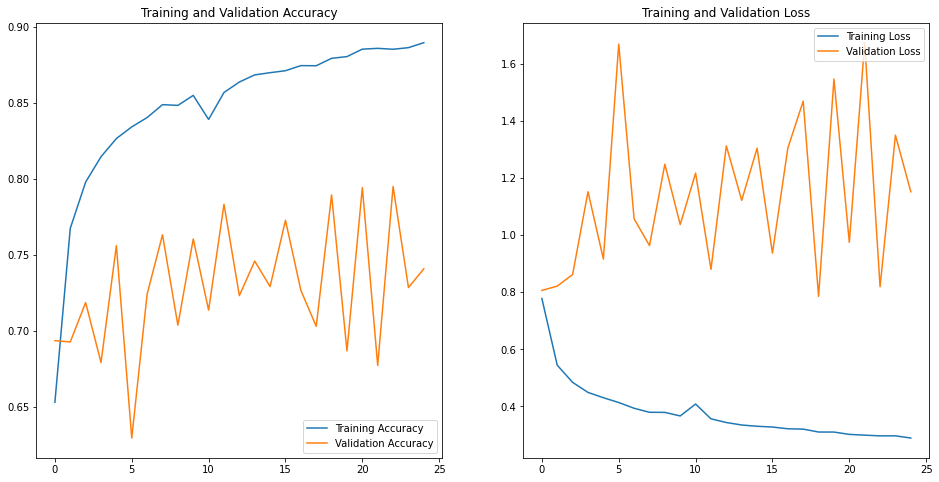

<Figure size 432x288 with 0 Axes>

In [15]:
epochs=25

tf.debugging.set_log_device_placement(True)

model = create_model()
if tf.test.is_gpu_available():
    with tf.device('/gpu:0'):
        history = model.fit(train_set,validation_data = test_set,epochs=epochs, callbacks=[model_checkpoint_callback])
else:
    history = model.fit(train_set,validation_data = test_set,epochs=epochs, callbacks=[model_checkpoint_callback])

model.summary()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("../images/Courbe_loss_et_accuracy.png")

#### Schéma du CNN

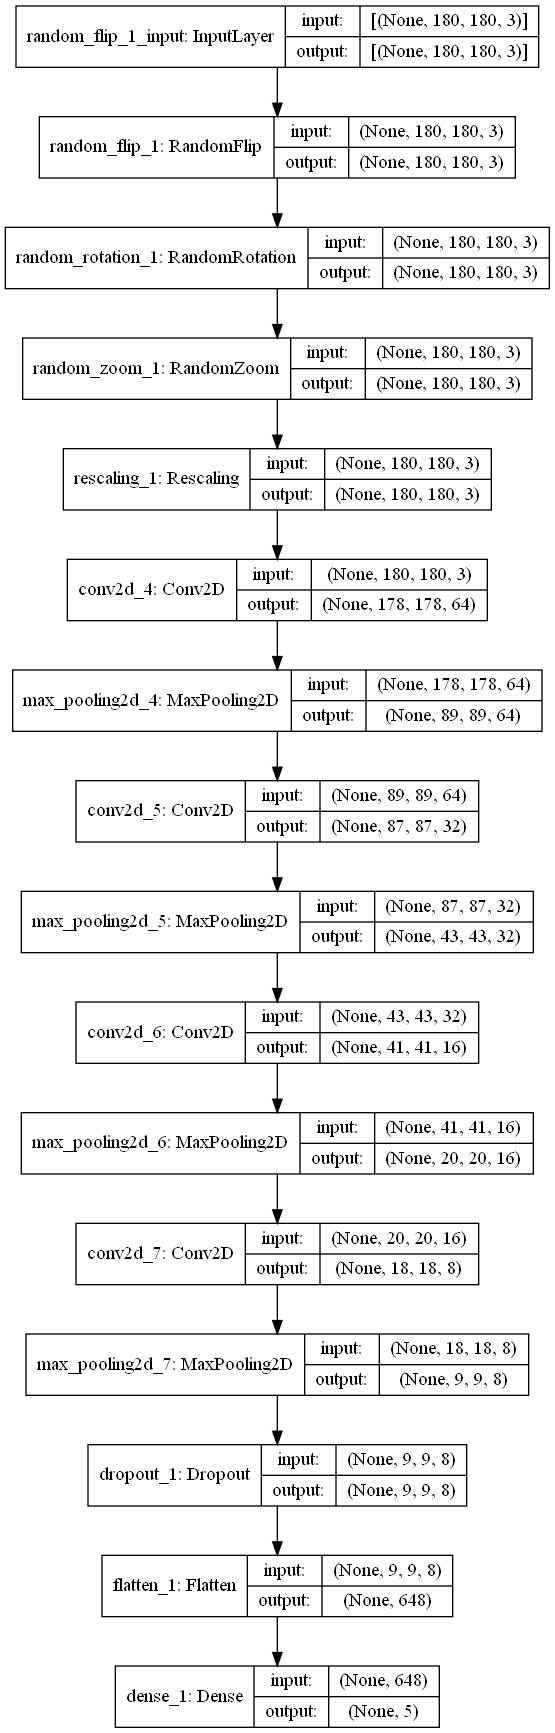

In [16]:
tf.keras.utils.plot_model(model, to_file='../images/model.png', show_shapes=True)

#### Chargement du modèle précedement sauvegardé.

In [17]:
new_model = tf.keras.models.load_model('../model/my_best_model.epoch11-loss0.62.hdf5')
score, accuracy = new_model.evaluate(test_set, batch_size=batch_s)
print('Loss : ', score)
print('Global Accuracy : ', accuracy)

259/259 [==============================] - 2s 9ms/step - loss: 0.6205 - accuracy: 0.8206

Résultats du modèle sauvegardé.

259/259 [==============================] - 2s 6ms/step - ETA: 1s

C:\Users\nicos\PycharmProjects\DataScience\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass display_labels=['Painting', 'Photo', 'Schematics', 'Sketch', 'Text'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


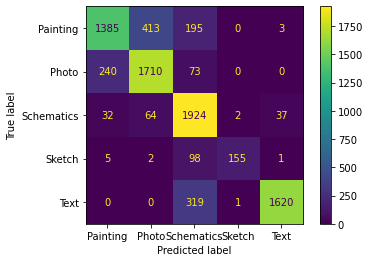

In [18]:
predictions = new_model.predict(test_set,verbose=1)

list_labels = []
for image_batch, label_batch in test_set:
    [list_labels.append(y.numpy()) for y in label_batch]

new_confus_mtx = sk.metrics.confusion_matrix(list_labels,predictions.argmax(axis=1))

disp = sk.metrics.ConfusionMatrixDisplay(new_confus_mtx,class_names)
disp.plot()

On voit que notre modèle à une `accuracy globale` de 0.82. Dans notre cas nous voulons distinguer les photos parmi tout les documents. Nous allons donc calculer `l'accuracy` pour la classe `Photo`.

In [19]:
per_class_accuracies = {}
# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(range(len(class_names))):
    true_negatives = np.sum(np.delete(np.delete(new_confus_mtx, idx, axis=0), idx, axis=1))
    true_positives = new_confus_mtx[idx, idx]
    per_class_accuracies[class_names[cls]] = (true_positives + true_negatives) / np.sum(new_confus_mtx)
print(per_class_accuracies)

{'Painting': 0.8927406691629424, 'Photo': 0.9043362724966784, 'Schematics': 0.9009542215243387, 'Sketch': 0.9868341587148206, 'Text': 0.9563956999637637}


## Bilan / Analyse des résultats

Nous avons choisi un `CNN Multi-Classifieur` pour traiter l'ensemble des données. L'entreprise voulant automatiser la sélection de photos. Nous regardons l'efficacité de notre réseau par la metric `d'accuracy` qui nous affiche les bonnes prédictions par rapport aux prédictions manquées. Dans le cas de notre classe `Photo`, nous atteignons une `accuracy` de `0.90`. Ce score est satisfaisant mais un `Classifieur Binaire` pourrait donner de meilleurs résultats. Nos erreurs de classification sont minimes. Elles sont principalement dû à une confusion pour le modèle entre une photo et une peinture mais également sur des photos classé par l'entreprise dans la classe `schematics`. Ce dernière point peut être l'objet d'une erreure humaine de classification des documents étant données que l'on retrouve des photos complètes dans la classe `schematics`.

![Result_training](images/Courbe_loss_et_accuracy.png)

<br>On voit sur notre graphe que notre modèle Overfit légèrement sur nos données d'entrainement, on remarque que la courbe du loss et de l'accuracy sur nos données de validations ne progressent plus au dela d'un certain seuil contrairement à nos données d'entrainement.
<br>Pour améliorer nos résultats nous pouvons appliquer une méthode de transfer learning pour avoir un réseau plus gros et une extraction plus fine des features ce qui nous donne une meilleur précision. Nous pouvons également construire plusieurs modèles spécialisé puis les concaténer dans le but de créer un modèle plus robuste qui devrait avoir de meilleur résultat tout en limitant les risques d'overfit/underfit. Egalement une cross validation peut être mis en place pour 

In [20]:
Photo_Painting_model = tf.keras.models.load_model('../model/my_best_model_Photo_Painting.epoch16-loss0.37.hdf5')
Photo_Schementic_model = tf.keras.models.load_model('../model/my_best_model_Photo_Schementic.epoch10-loss0.12.hdf5')
Photo_Sketch_model = tf.keras.models.load_model('../model/my_best_model_Photo_Sketch.epoch18-loss0.01.hdf5')
Photo_Text_model = tf.keras.models.load_model('../model/my_best_model_Photo_Text.epoch10-loss0.01.hdf5')
all_model = [Photo_Painting_model, Photo_Schementic_model, Photo_Sketch_model, Photo_Text_model]

In [21]:
import Classifier_Binary

def all_binary_classifier(train_set, test_set, batch_s, model):
    Classifier_Binary.autotune_Dataset(train_set, test_set)
    score, accuracy = model.evaluate(test_set, batch_size=batch_s)
    print('Loss : ', score)
    print('Global Accuracy : ', accuracy)
    return model.predict(test_set, verbose=1).argmax(axis=1)

def all_classifier(train_set, test_set, batch_s, all_model):
    predictions_list = []
    for model in all_model:
        predictions_list.append(all_binary_classifier(train_set, test_set, batch_s, model))
    return predictions_list

def pred_multi_binary_model(batch_size, dataset_binary):
    train_set, test_set = Classifier_Binary.dataset(dataset_binary, image_h=180, image_w=180,
                                                    batch_s=batch_size)
    pred = all_classifier(train_set, test_set, batch_size, all_model)
    print(pred)
    labels_pred = []
    for p1, p2, p3, p4 in zip(pred[0], pred[1], pred[2], pred[3]):
        res = p1 + p2 + p3 + p4
        proba = res / 4 if res != 0 else res
        labels_pred.append(1 if proba > 0.5 else 0)
    labels = []
    for image_batch, label_batch in test_set:
        [labels.append(y.numpy()) for y in label_batch]

    print(confusion_matrix(labels, labels_pred))

    new_confus_mtx = sk.metrics.confusion_matrix(labels,labels_pred)
    disp = sk.metrics.ConfusionMatrixDisplay(new_confus_mtx,display_labels=test_set.class_names)
    disp.plot()

In [ ]:
Classifier_Binary.process_model(model_name="Photo_Painting",epochs=25,data_dir='../Dataset_Binary_Project/Project_Dataset_Ph_Pa')
Classifier_Binary.process_model(model_name="Photo_Schementic",epochs=25,data_dir='../Dataset_Binary_Project/Project_Dataset_Ph_Sh')
Classifier_Binary.process_model(model_name="Photo_Sketch",epochs=25,data_dir='../Dataset_Binary_Project/Project_Dataset_Ph_Sk')
Classifier_Binary.process_model(model_name="Photo_Text",epochs=25,data_dir='../Dataset_Binary_Project/Project_Dataset_Ph_Te')

Found 18903 files belonging to 2 classes.
Using 15123 files for training.
Found 18903 files belonging to 2 classes.
Using 3780 files for validation.
['Photo', 'all_pictures']
119/119 [==============================] - 5s 36ms/step - loss: 2.4578 - accuracy: 0.1966

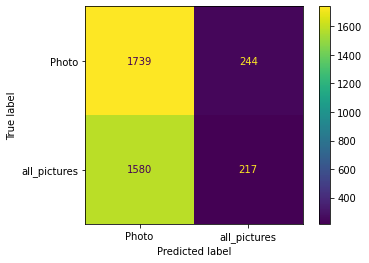

In [22]:
pred_multi_binary_model(32,"../Dataset_Binary_Project_test/")